In [1]:
from multifitoolbox import * 
import matplotlib.pyplot as plt

# Plot parameters 
plt.rcParams.update({
    "font.family": "georgia",
    'text.latex.preamble': r'\\usepackage{amsmath}',
    'mathtext.fontset': 'cm',
})

# Define number of low-fidelity functions 
K = 2 

# Define a list of sample sizes
sample_sizes = [10, 25, 50]

# Define the low-fidelity functions
funcs = [
    lambda x: np.exp(-x) * np.sin(2*math.pi*x), 
    lambda x: np.sin(2*math.pi*x),
    lambda x: np.exp(-x)
]

xmin = 0
xmax = 5

Xtest = np.linspace(xmin,xmax,1000).reshape(1,-1)
Ytest = funcs[0](Xtest.ravel())

# Creating data dictionary
d = {}

# Generating nested data 
for k in range(K+1):
    np.random.seed(43)
    # Generating the input data 
    d[k] = {
        'X':np.random.uniform(xmin, xmax, size=sum(sample_sizes[:k+1])).reshape(1, -1), 
    }
    # Generating the output training data
    d[k]['Y'] = funcs[k](d[k]['X']).ravel()

    # Standard Scaling scaling the high-fidelity function testing data
    if k == 0:
        Ytest = (Ytest - np.mean(d[0]['Y'])) / np.std(d[k]['Y'])
    
    # Standard Scaling the training evaluations (converges better)
    d[k]['Y'] = (d[k]['Y'] - np.mean(d[k]['Y'])) / np.std(d[k]['Y'])

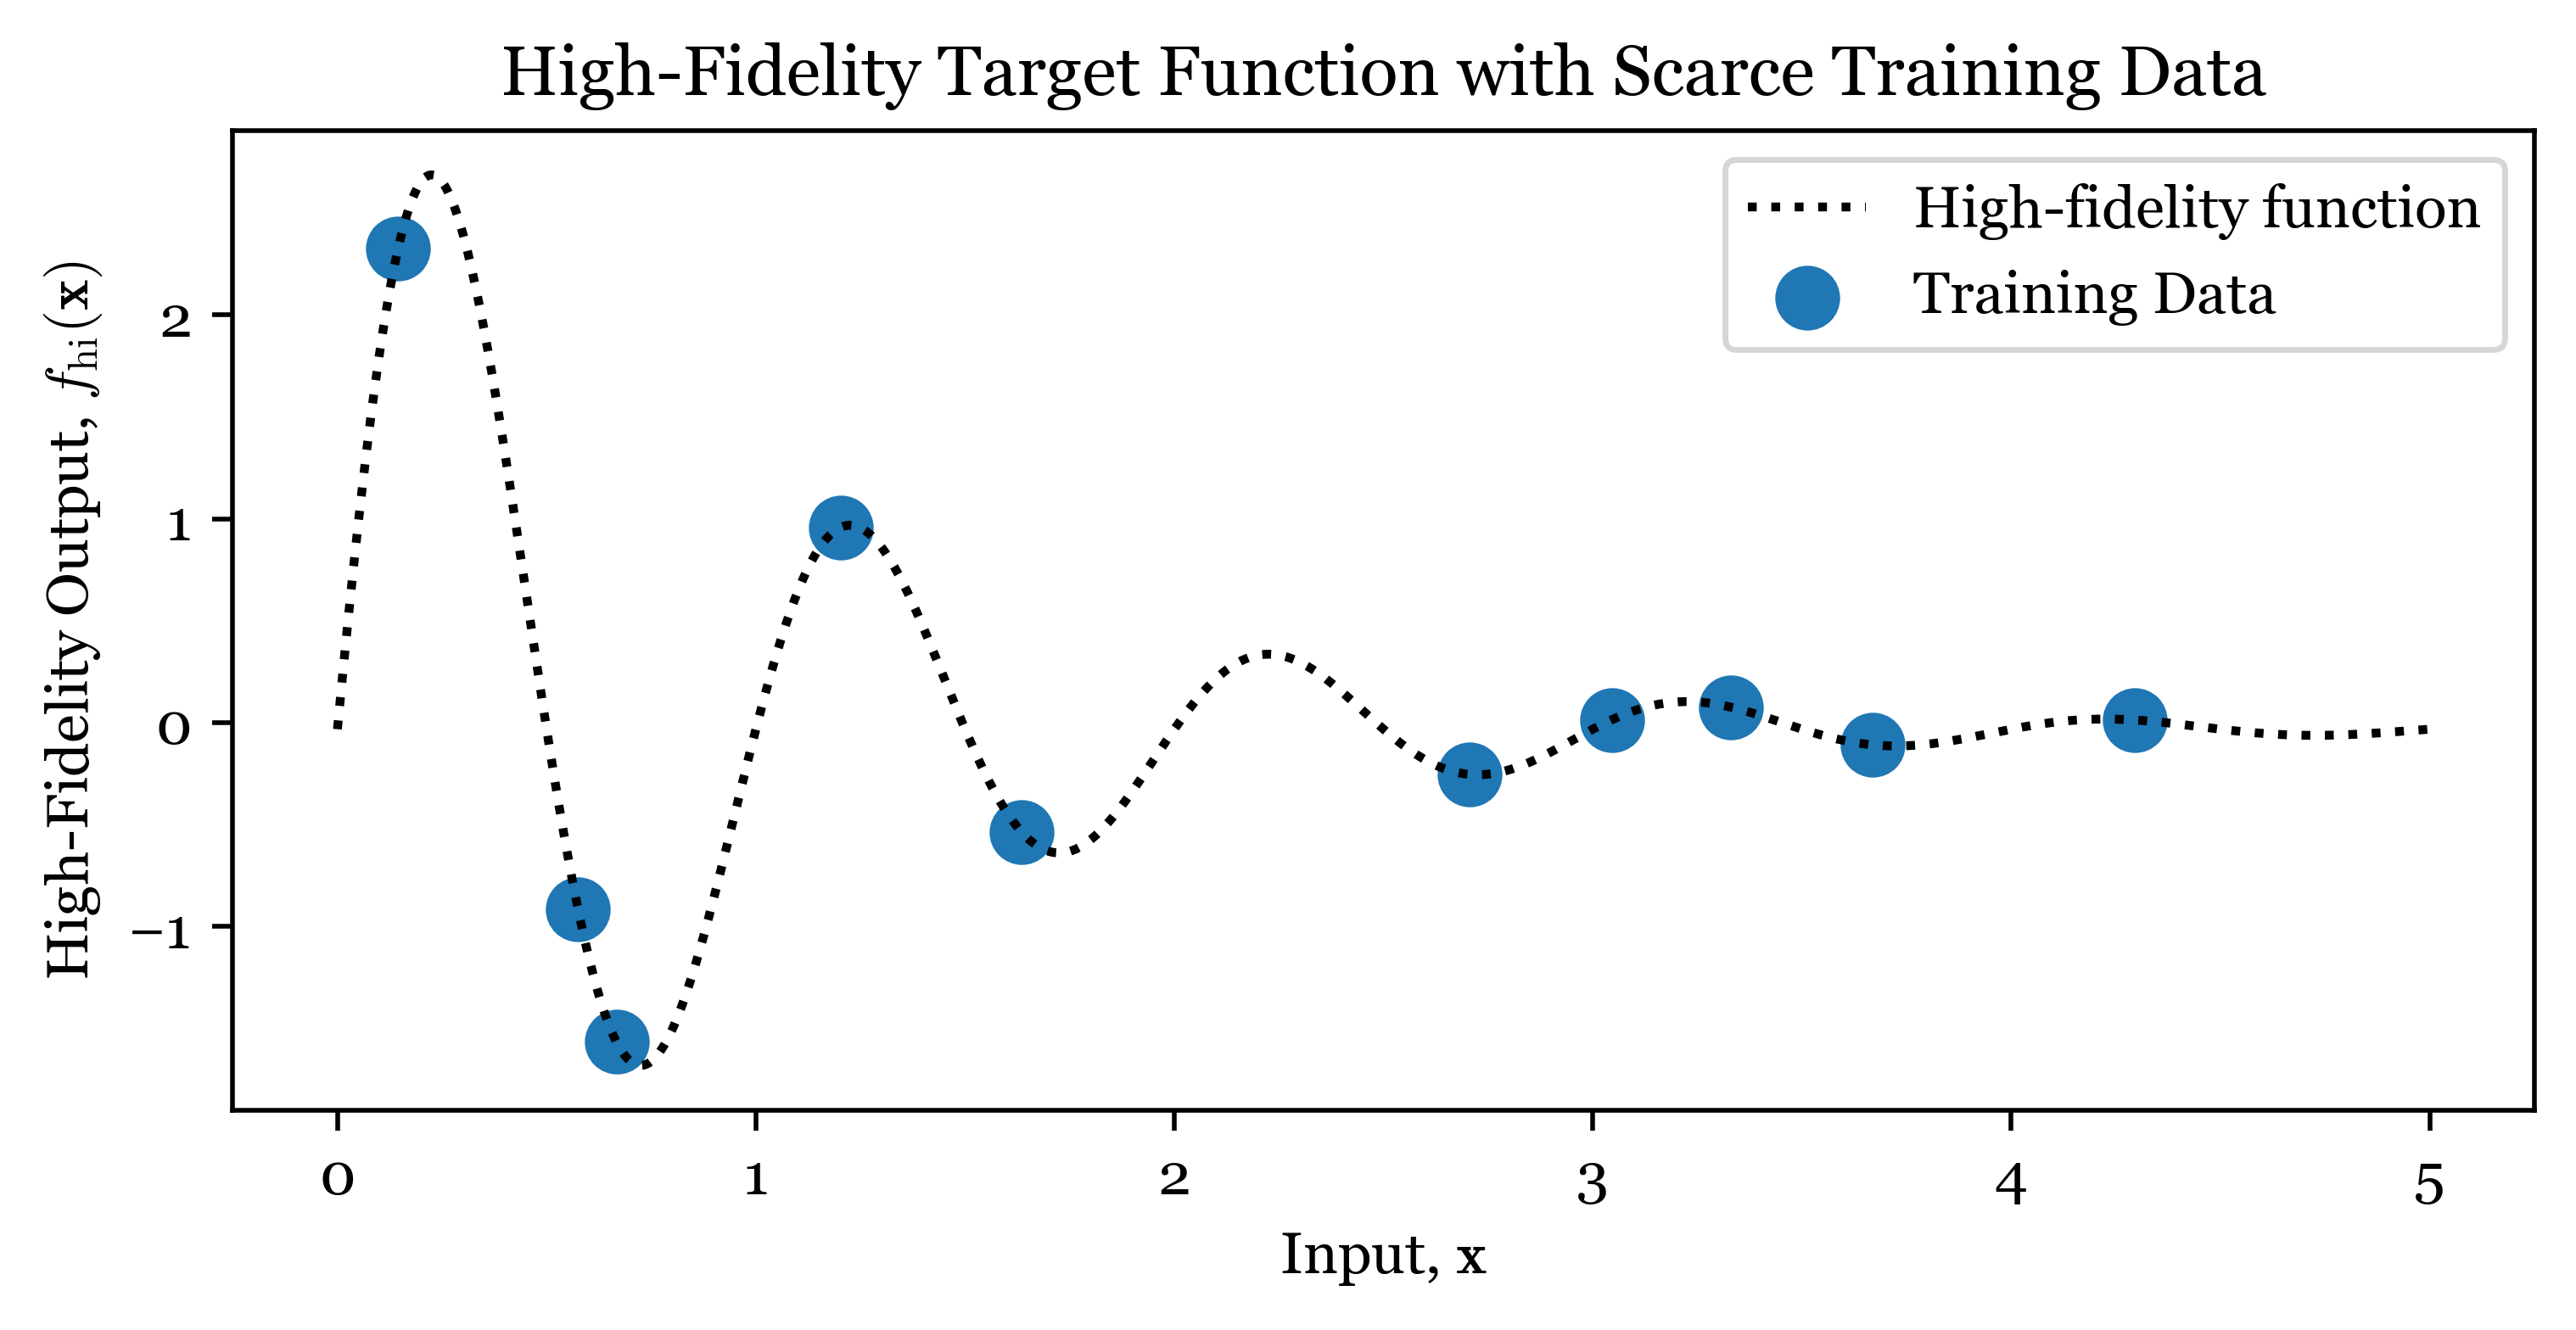

In [2]:
plt.figure(figsize=(7, 3), dpi=500)
plt.plot(Xtest.ravel(), Ytest, color='black', linestyle = 'dotted', label='High-fidelity function')
plt.scatter(d[0]['X'].ravel(), d[0]['Y'], s = 100.0, label='Training Data')
plt.xlabel("Input, $\mathbf{x}$")
plt.ylabel("High-Fidelity Output, $f_{\\text{hi}}(\mathbf{x})$")
plt.title("High-Fidelity Target Function with Scarce Training Data")
plt.legend()

# Low-Fidelity Regression: 

$$ f_1(\mathbf{x}) = \exp(-\mathbf{x}) \quad  \mathcal{Z}_{1}(\mathbf{x}) = \begin{bmatrix} \mathbf{x} \end{bmatrix} \quad \boldsymbol{\kappa}:\mathbb{R} \times \mathbb{R} \mapsto \mathbb{R}$$

Warning! Kernel Matrix is close to singular: K=108677728
Initial Loss: -474.81226


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\arex8\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\jax\_src\interpreters\xla.py:135: RuntimeWarning: overflow encountered in cast
  return np.asarray(
100%|██████████| 100/100 [00:02<00:00, 47.64it/s, Current Loss: -478.19238 Learning Rate: 1.00e+00]


Final Loss: -478.99152

Warning! Kernel Matrix is close to singular: K=185505072


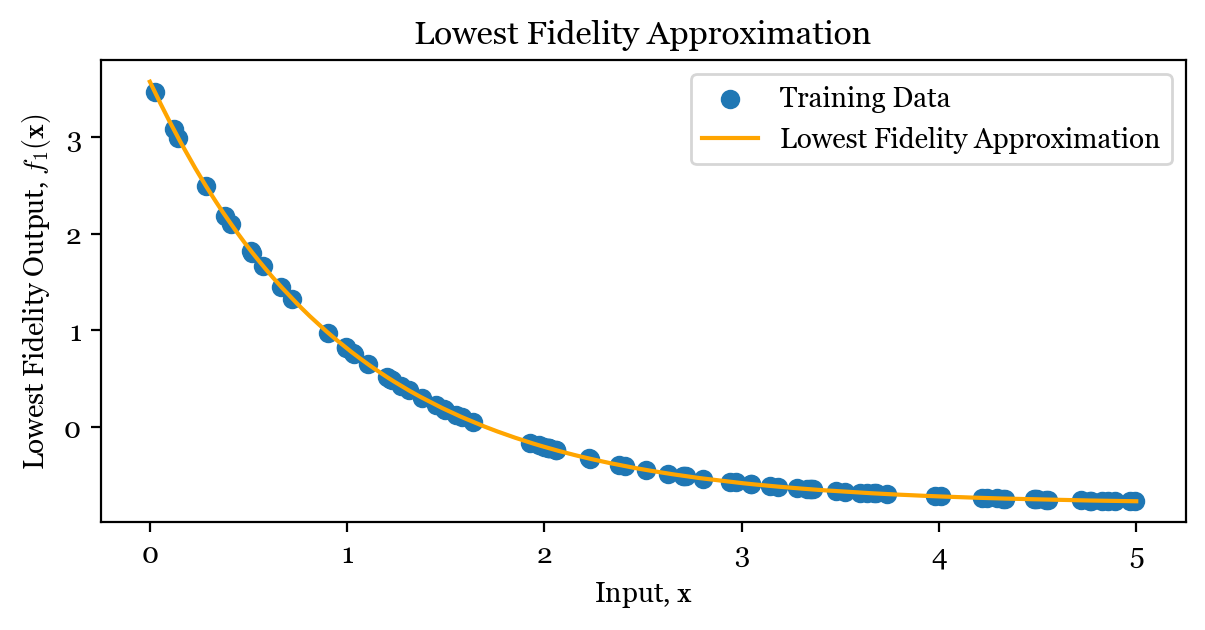

In [3]:
# Instantiate the model 
g1 = GaussianProcess()

# Fit the model using a guess at kernel parameters (small regularization is often necessary)
param_guess = np.ones(1)
g1.fit(d[2]['X'], d[2]['Y'], param_guess, noise_var = 1e-6)

# Optimize the kernel parameters
g1.optimize_kernel_params(param_guess, lr = 1, max_iter = 100)

# Make online predictions on test inputs
g1_test, g1_std = g1.predict(Xtest, include_std = True)
g1_std *= 2.15

# Plotting the results
plt.figure(figsize=(7, 3), dpi=200)
plt.scatter(d[2]['X'].ravel(), d[2]['Y'], label='Training Data')
plt.plot(Xtest.ravel(), g1_test.ravel(), color='orange', label = "Lowest Fidelity Approximation")
plt.fill_between(Xtest.ravel(), g1_test.ravel()-g1_std.ravel(), g1_test.ravel()+g1_std.ravel(), color='orange', alpha=0.3)
plt.xlabel("Input, $\mathbf{x}$")
plt.ylabel("Lowest Fidelity Output, $f_{1}(\mathbf{x})$")
plt.title("Lowest Fidelity Approximation")
plt.legend()

# Middle-Fidelity Regression: 

$$ f_2(\mathbf{x}) = \sin(2 \pi \mathbf{x}) \quad  \mathcal{Z}_{2}(\mathbf{x}) = \begin{bmatrix} \mathbf{x} \\ f_1(\mathbf{x}) \end{bmatrix} \quad \boldsymbol{\kappa}:\mathbb{R}^2 \times \mathbb{R}^2 \mapsto \mathbb{R}$$

Initial Loss: 14852.83496


100%|██████████| 500/500 [00:07<00:00, 68.35it/s, Current Loss: -34.26652 Learning Rate: 1.00e-02]


Final Loss: -34.26652



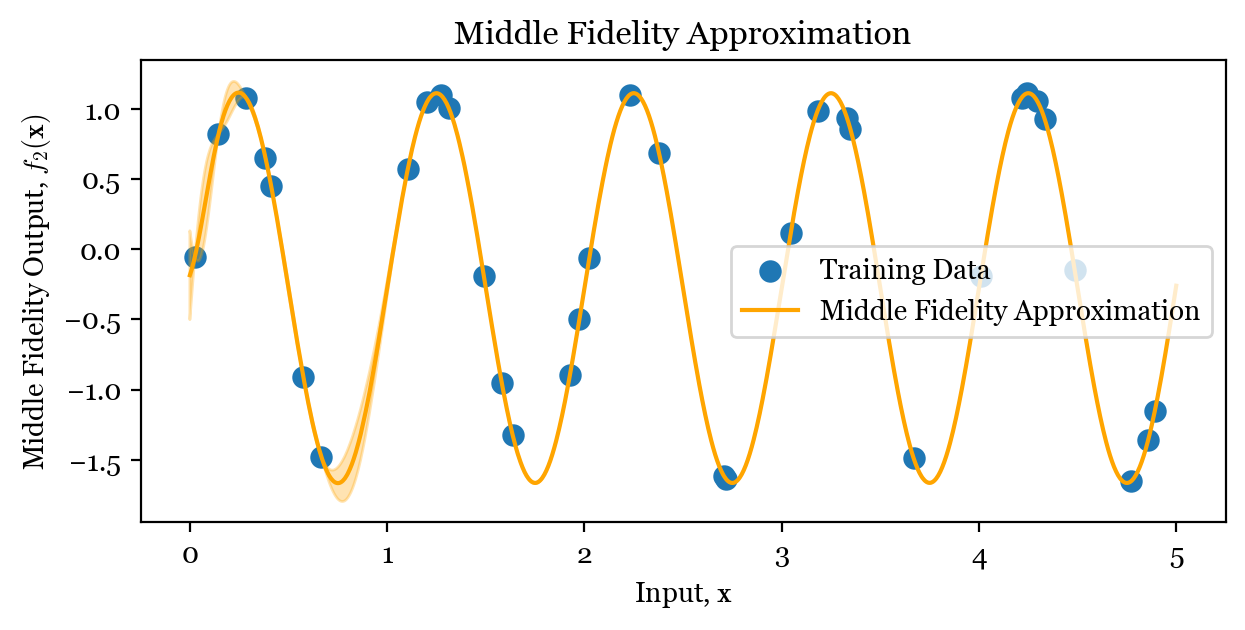

In [4]:
# Instantiate the model 
g2 = GaussianProcess()

# Fit the model with a kernel parameter guess 
param_guess = np.ones(2)
g2.fit(
    np.vstack((d[1]['X'], d[2]['Y'][:sum(sample_sizes[0:2])].reshape(1,-1))), 
    d[1]['Y'],param_guess, noise_var = 1e-6)

# Optimize the kernel parameters 
g2.optimize_kernel_params(param_guess, lr = 1e-2, max_iter = 500)

# Make online predictions at the test inputs
g2_test, g2_std = g2.predict(
    np.vstack((Xtest,g1_test.reshape(1,-1))), 
    include_std = True)
g2_std *= 2.15

plt.figure(figsize=(7, 3), dpi=200)
inds = np.argsort(d[1]['X'].ravel())
plt.scatter(d[1]['X'].ravel(), d[1]['Y'],s = 50.0, label='Training Data')
plt.plot(Xtest.ravel(), g2_test.ravel(), color='orange', label = "Middle Fidelity Approximation")
plt.fill_between(Xtest.ravel(), g2_test.ravel()-g2_std.ravel(), g2_test.ravel()+g2_std.ravel(), color='orange', alpha=0.3)
plt.xlabel("Input, $\mathbf{x}$")
plt.ylabel("Middle Fidelity Output, $f_{2}(\mathbf{x})$")
plt.title("Middle Fidelity Approximation")
plt.legend()

# High-Fidelity Regression: 

$$ f_{\text{hi}}(\mathbf{x}) = \sin(2 \pi \mathbf{x})\exp(-\mathbf{x}) \quad  \mathcal{Z}_{2}(\mathbf{x}) = \begin{bmatrix} \mathbf{x} \\ f_1(\mathbf{x}) \\ f_2(\mathbf{x}) \end{bmatrix} \quad \boldsymbol{\kappa}:\mathbb{R}^3 \times \mathbb{R}^3 \mapsto \mathbb{R}$$

In [5]:
# Instantiate the model 
g3 = GaussianProcess(double_precision = True)

# Fit the model to a parameter guess 
param_guess = np.ones(3)
g3.fit(
    np.vstack((
        d[0]['X'], # inputs 
        d[1]['Y'][:sum(sample_sizes[0:1])], # middle-fidelity data
        d[2]['Y'][:sum(sample_sizes[0:1])].reshape(1,-1))), # low-fidelity data
    d[0]['Y'], 
    param_guess, 
    noise_var = 1e-6)

# Optimize the kernel parameters 
g3.optimize_kernel_params(param_guess, lr = 5, max_iter = 1000)

# Make test predictions w/ uncertainty estimation
g3_test, g3_std = g3.predict(
    np.vstack((
        Xtest,
        g2_test.reshape(1,-1), 
        g1_test.reshape(1,-1)
    )), 
    include_std = True)

# Creating 95% confidence interval with predictions
g3_std *= 2

Initial Loss: 3.89912


100%|██████████| 1000/1000 [00:14<00:00, 69.91it/s, Current Loss: -4.27006 Learning Rate: 5.00e+00]


Final Loss: -4.27006



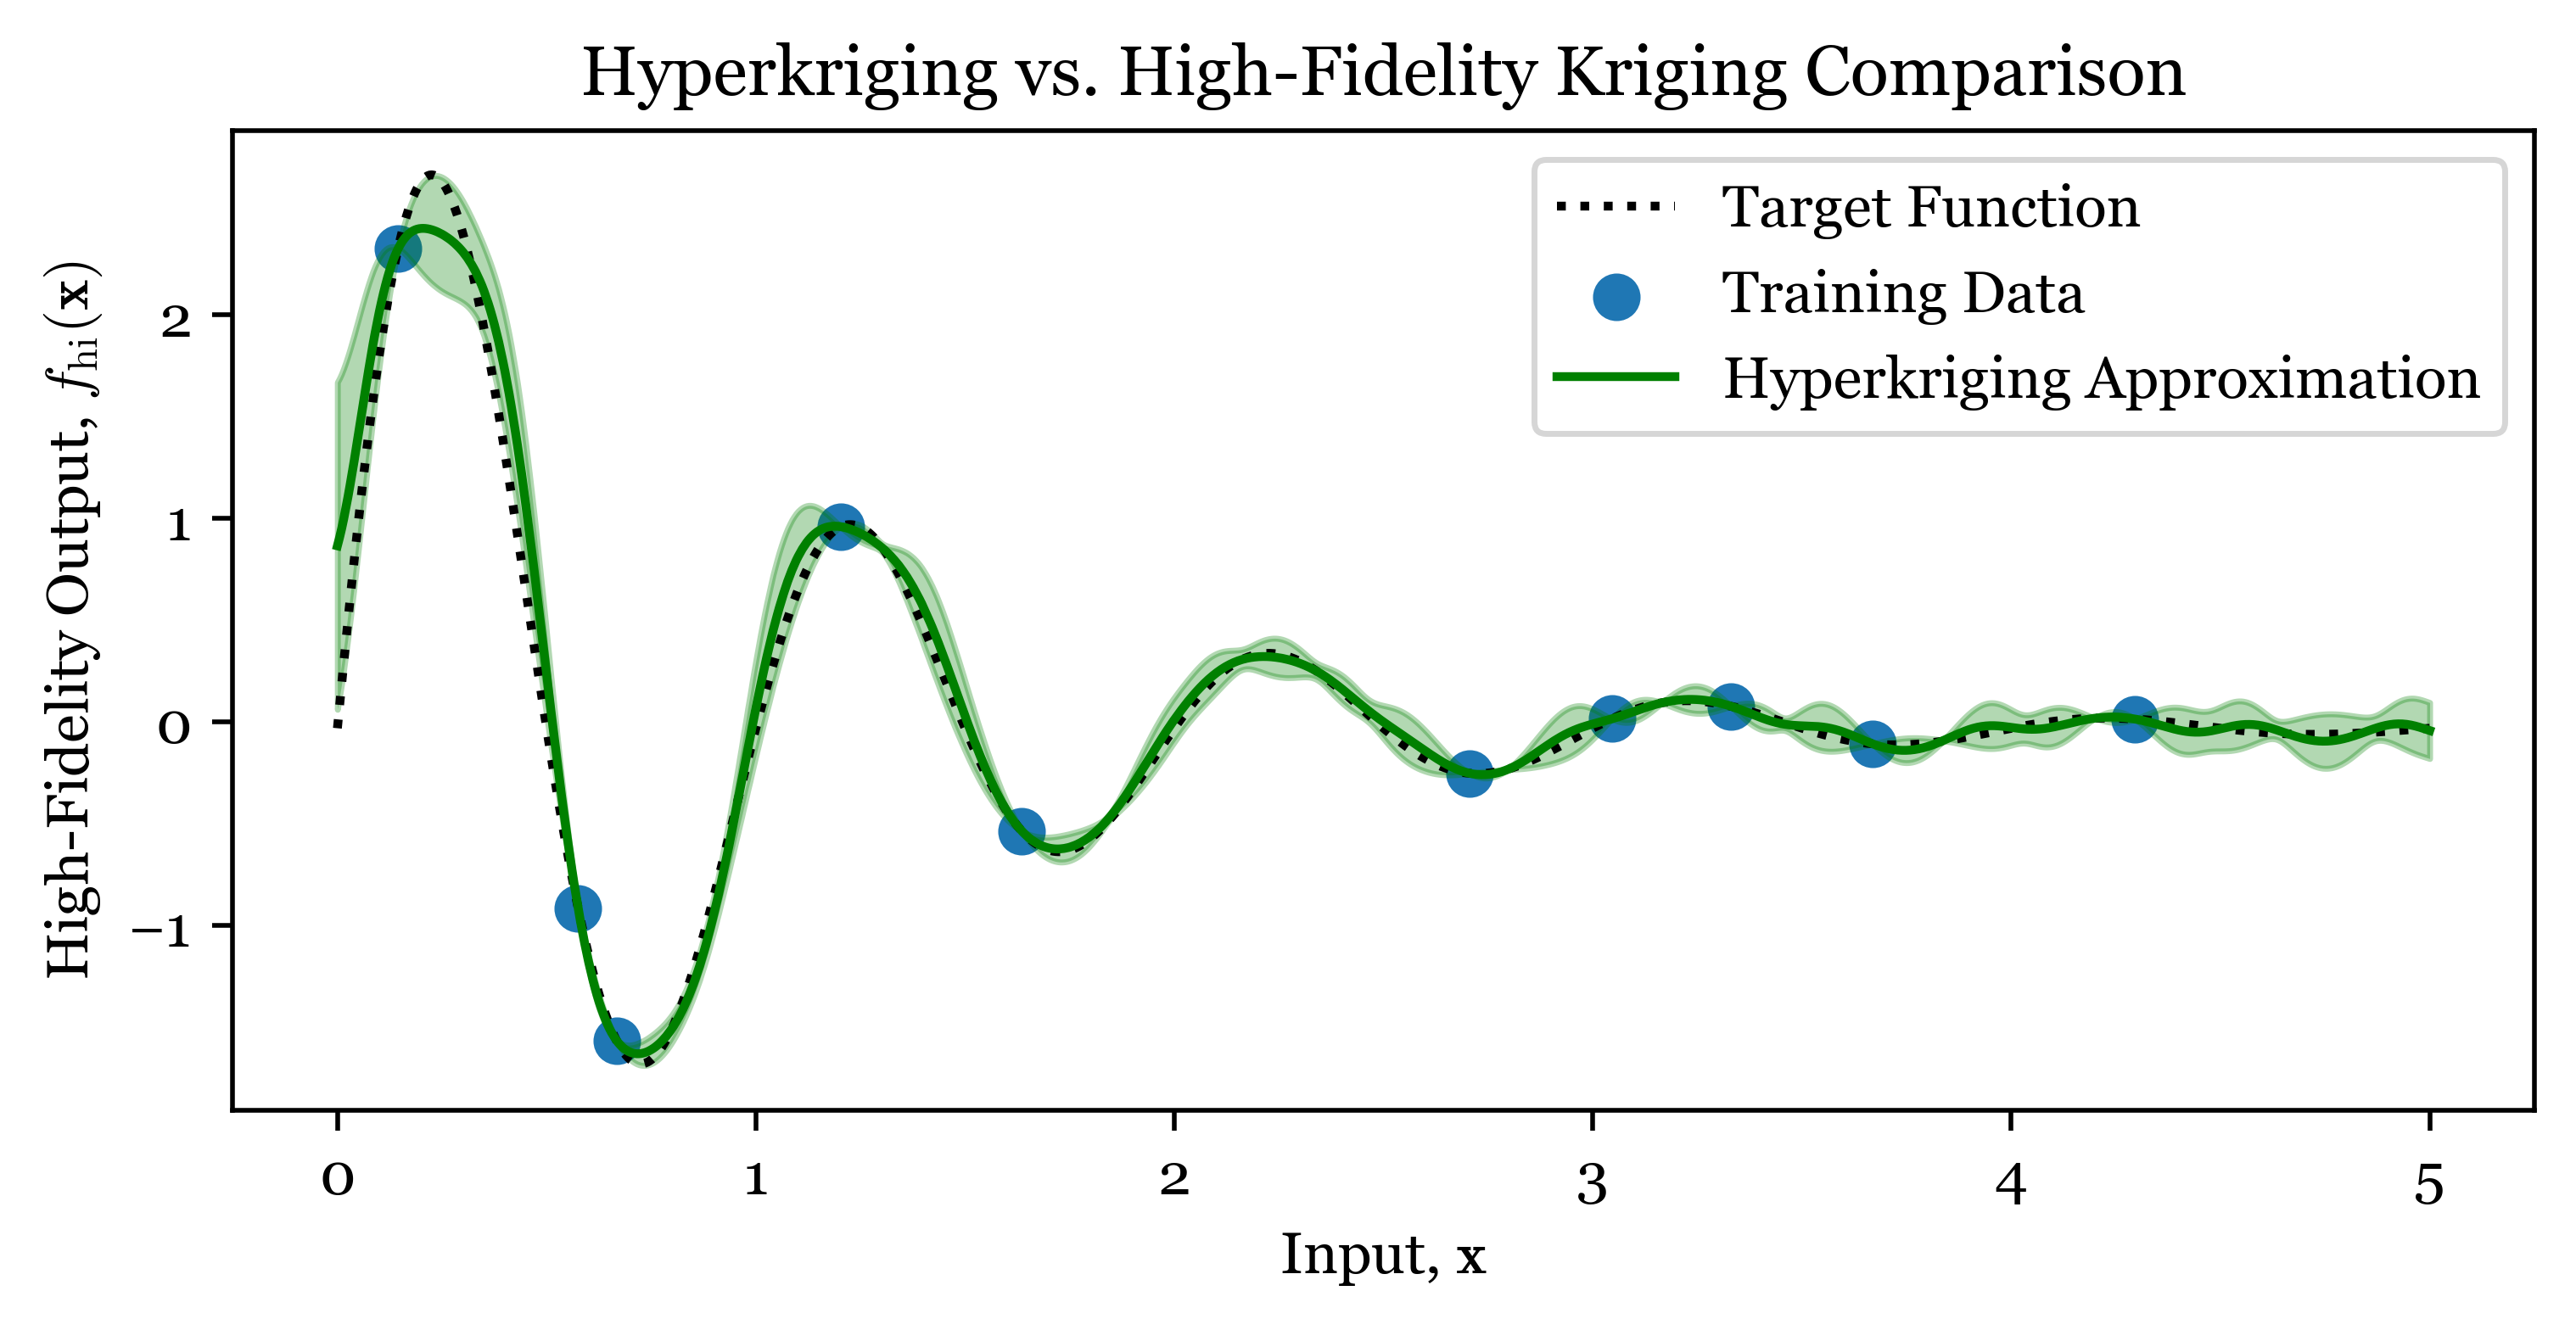

In [6]:
plt.figure(figsize=(7, 3), dpi=500)
plt.plot(Xtest.ravel(), Ytest, color='black', linestyle = 'dotted', label='Target Function')
plt.scatter(d[0]['X'].ravel(), d[0]['Y'],s = 50.0, label='Training Data')
plt.plot(Xtest.ravel(), g3_test.ravel(), color='green', label = "Hyperkriging Approximation")
plt.fill_between(Xtest.ravel(), g3_test.ravel()-g3_std.ravel(), g3_test.ravel()+g3_std.ravel(), color='green', alpha=0.3)

plt.xlabel("Input, $\mathbf{x}$")
plt.ylabel("High-Fidelity Output, $f_{\\text{hi}}(\mathbf{x})$")
plt.title("Hyperkriging vs. High-Fidelity Kriging Comparison")
plt.legend()